In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm

## Read the data
Read the data, then apply binarization. We convert the ratings to '1' when rating value is higher than 3. 

In [2]:
import zipfile
import pandas as pd
with zipfile.ZipFile("./../data/ml-latest-small.zip") as z:
    with z.open("ml-latest-small/ratings.csv") as f:
        ratings = pd.read_csv(f, delimiter=",")

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
ratings['datetime'] = ratings['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x / 1000.0))
ratings["date"] = pd.to_datetime(ratings['datetime']).dt.date
interactions = ratings[ratings.rating > 3]
ratings.shape, interactions.shape

((100836, 6), (61716, 6))

In [5]:
interactions.userId.nunique(), interactions.movieId.nunique()

(609, 7363)

## Split the data
Split the data based on timestamp. First let's inspect number of interactions per day in our dataset.

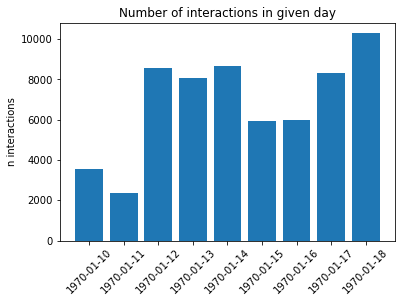

In [6]:
n_interactions = interactions.groupby("date").agg(n_obs=("userId","count")).reset_index()
n_interactions
plt.bar(n_interactions.date, n_interactions.n_obs)
plt.title("Number of interactions in given day")
plt.ylabel("n interactions")
plt.xticks(rotation=45)
plt.show()

Let's split the data on the last day. So in our example this will be day "1970-01-18". <br />
**Question: <br /> What are the advantages and disadvantages of such split compared to other types of splits? For other types of splitting consider random split* and leave-one-out split\**.** <br />
\* Random split is just randomly selecting interactions for test set. <br />
\** Leave-one-out split is selecting just one item for each user. Assume that we know temporal ordering and in such case leave-one-out selects last item from each user interaction history. Recall, that's not the same ase leave-one-out cross validation strategy!!!

**Answer:** TODO

In [7]:
split_date = "1970-01-18"
train = interactions[interactions.datetime < split_date]
test = interactions[interactions.datetime >= split_date]
train.datetime.max(), len(train), test.datetime.min(), len(test)

(Timestamp('1970-01-17 23:59:44.741000'),
 51431,
 Timestamp('1970-01-18 00:04:28.014000'),
 10285)

Our train and test datasets look valid. We have around 50k and 10k observations in train and test, respectively. Due to the nature of choosen split latter number can change. <br />
**Question: <br />
Why is that?**

**Answer:** <br />
We haven't checked if all users (or items) from test set have at least one interaction in train set. If there is no interaction for given user / item in train set the model won't be able to learn how to generate recommendations for given user or item. Therefore, we may need to remove users (or items) which are not present in train set

In [8]:
users, items = train.userId.unique(), train.movieId.unique()
n_users, n_items = len(users), len(items)
users_df = pd.DataFrame(users, columns=["userId"])
items_df = pd.DataFrame(items, columns=["movieId"])
u_to_ids = {user:idx for idx,user in enumerate(users)}
i_to_ids = {item:idx for idx,item in enumerate(items)}
train["users_mapped"] = train["userId"].apply(lambda x: u_to_ids[x])
train["items_mapped"] = train["movieId"].apply(lambda x: i_to_ids[x])
n_users, n_items

C:\Users\marzecm\AppData\Local\Temp\ipykernel_14972\1918217346.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["users_mapped"] = train["userId"].apply(lambda x: u_to_ids[x])
C:\Users\marzecm\AppData\Local\Temp\ipykernel_14972\1918217346.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["items_mapped"] = train["movieId"].apply(lambda x: i_to_ids[x])


(532, 6236)

In [9]:
print(f"Test n obs before merge = {test.shape[0]}")
test_valid = test.merge(users_df, on="userId").merge(items_df, on="movieId")
print(f"Test n obs after merge = {test_valid.shape[0]}")

Test n obs before merge = 10285
Test n obs after merge = 803


It looks like we have removed more than 90% of test set! This is very rare situation, but we are working on educational dataset, so this is not that important. It is just a subset of the whole MovieLens dataset, and we don't know how exactly the data was collected.

## Model
In currect section we will implement Matrix Factorization model (and Neural Matrix Factorization model) 
### Matrix Factorization
**Exercise:**<br /> Implement matrix factorization model. Use the cell below as a guide (change given functions).

In [10]:
class MF(nn.Module):
    def __init__(self, n_factors=None):
        pass
    
    def forward(self, user, item):
        pass
        

In [11]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_factors=None, n_users=None, n_items=None):
        super().__init__()
        self.n_factors = n_factors
        self.users = nn.Embedding(n_users, n_factors)
        self.items = nn.Embedding(n_items, n_factors)
    
    def forward(self, user, item):
        user_emb, item_emb = self.users(user), self.items(item)
        return (user_emb * item_emb).sum(dim=1)

### Neural Matrix Factorization

In [12]:
# TODO

## Evaluation
Evaluation of the recommender system can be performed in various settings. The two main ways to do so are online evaluation and offline evaluation. The online evaluation uses a continuous stream of users feedback to access system performance. In practice, it is often difficult to design settings allowing for such evaluation. Offline evaluation is based on historical data and it is the most common way of evaluating recommender system models. When designing evaluation methodology for a recommender system, we have to consider our goals. In the early stages of research in this field, calculating RMSE, MSE or MAE (Mean Absolute Error) was a very popular way of accessing the performance of the recommender system. This was, of course, connected with the data availability - the main datasets available online consisted of explicit ranking. Therefore, recommendation problem was often treated as a regression problem so typical regression metrics were used. When the data was in a binary form - metrics based on classification were used. The current standard are ranking based metrics. They give the biggest weights to the items placed at the top of the ranking list, which mimics the goal of top-k recommendation. <br /> In this tutorial we will focus on **Recall@k** which is a metric build upon Recall used for standard classification problems. For a given user we can define: $$Recall@k = \frac{number\ of\ relevant\ items}{total\ number\ of\ items},$$ the number $k$ is the length of the recommendation list. To calculate Recall@k for the whole dataset we average the values of recall for each user. <br />

As we don't have negative interactions we can sample (again ;)) negatives for users from test set. For each user we sample 100 items, and consider them negative. Then if we want to calculate Recall@10 for user $u$ with two items in test set, we need to score all 102 items, and order them accordingly to obtained scores (higher score means higher probability of interaction). For Recall@10 we need to check how many of these two relevant items are in top-10 recommendation list and divide it by the total number of relevant items for this user (=2 in this case). 


**Exercise:**<br />
Implement function for calculating the recall for a given user. Then sample 100 negative items for each user (items have to be different from what is in given user's test set). Calculate recall at cutoffs k=5,10,30 for untrained model. Note: Your recall function doesn't have to have specific arguments defined below, but the solution will refer to them.

In [14]:
def recall_k(k=10, annotated_preds=[]):
    pass
    # k - cutoff value
    # preds - list with tuples (probability, 0/1) indicating predicted scores and label

**Solution:**

In [15]:
test_positives = test_valid.groupby("userId")["movieId"].agg(lambda x: x.tolist())

items_set = set(items)
positives_test = {}
negatives_test = {}
for u,i_pos in zip(test_positives.index, test_positives):
    sampled = np.random.choice(list(items_set - set(i_pos)), size=100, replace=False)
    positives_test[u] = i_pos
    negatives_test[u] = sampled
    
# encode users and items for model
positives_test_encoded = {}
negatives_test_encoded = {}
for u,itms in positives_test.items():
    positives_test_encoded[u_to_ids[u]] = [i_to_ids[i] for i in itms]
for u,itms in negatives_test.items():
    negatives_test_encoded[u_to_ids[u]] = [i_to_ids[i] for i in itms]

In [16]:
# score positives and negatives
def score(model, positives_test_encoded, negatives_test_encoded):
    scored = defaultdict(list)
    for u, itms in positives_test_encoded.items():
        u_tensor = torch.tensor([u]).repeat(len(itms))
        itms = torch.tensor(itms)
        # evaluate model:
        model.eval()
        with torch.no_grad():
            preds = model(u_tensor, itms)
        for p in preds:
            scored[u].append((p.item(),1))

    for u, itms in negatives_test_encoded.items():
        u_tensor = torch.tensor([u]).repeat(len(itms))
        itms = torch.tensor(itms)
        # evaluate model:
        model.eval()
        with torch.no_grad():
            preds = model(u_tensor, itms)
        for p in preds:
            scored[u].append((p.item(),0))
    return scored

In [17]:
def recall_k(k=10, annotated_preds=[]):
    # k - cutoff value
    # preds - list with tuples (probability, 0/1) indicating predicted scores and label
    n = min(k, sum([i[1] for i in annotated_preds]))
    s = sorted(annotated_preds, key=lambda x: x[0], reverse=True)
    r = sum([i[1] for i in s[:k]])
    return r / n

In [19]:
# init random model
model = MatrixFactorization(n_factors=20, n_users=n_users, n_items=n_items)
scored = score(model, positives_test_encoded, negatives_test_encoded)
for k in [5,10, 30]:
    recalls = [recall_k(k, pred) for pred in scored.values()]
    mean_recall = np.mean(recalls)
    print(f"Recall@{k} = {mean_recall}")

Recall@5 = 0.2076923076923077
Recall@10 = 0.2192307692307692
Recall@30 = 0.2918701492828226


## Training

In [38]:
lr = 1e-3
batch_size = 64
n_epochs = 20

In [39]:
model = MatrixFactorization(n_factors=20, n_users=n_users, n_items=n_items)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.BCEWithLogitsLoss()

### Train without sampling

In [40]:
class MovieLensDataset(Dataset):
    def __init__(self, data, output_col="output"):
        self.users = data.users_mapped.values
        self.items = data.items_mapped.values
        if output_col:
            self.output = data[output_col].values
        else:
            self.output = np.ones(self.users.shape)
        
    def __len__(self):
        return len(self.users)
        
    def __getitem__(self, idx):
        return (self.users[idx], self.items[idx], self.output[idx])

In [41]:
dataset = MovieLensDataset(train, output_col=None)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [42]:
def train_fn(model, optimizer, n_epochs, dataloader, verbose_n_steps=None):
    epoch_losses = []
    global_step = 0
    epoch_loss = []
    for epoch in range(1, n_epochs+1):
        print(f"Running epoch {epoch}")
        tmp_loss = []
        for user, item, output in tqdm(dataloader):
            optimizer.zero_grad()

            # Predict and calculate loss
            prediction = model(user, item)
            loss = loss_function(prediction, output)

            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()

            global_step += 1
            epoch_loss.append(loss.item())
            
            if verbose_n_steps:
                # store current loss
                tmp_loss.append(loss.item())
            if verbose_n_steps and global_step % verbose_n_steps == 0:
                avg = np.mean(tmp_loss)
                print(f"Step = {global_step}, moving average loss = {avg}")
                tmp_loss = []
                
        e_loss = np.mean(epoch_loss)
        epoch_losses.append(e_loss)
        print(f"Avg loss after epoch {epoch}, is equal to {e_loss}")
        
    return epoch_losses

In [43]:
losses = train_fn(model, optimizer, n_epochs, dataloader, verbose_n_steps=None)

Running epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 397.20it/s]


Avg loss after epoch 1, is equal to 1.8580522157925798
Running epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 340.06it/s]


Avg loss after epoch 2, is equal to 1.7605639855676345
Running epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 370.42it/s]


Avg loss after epoch 3, is equal to 1.6689885777214621
Running epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 348.11it/s]


Avg loss after epoch 4, is equal to 1.58399221989539
Running epoch 5


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 309.03it/s]


Avg loss after epoch 5, is equal to 1.5054682094473606
Running epoch 6


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 350.01it/s]


Avg loss after epoch 6, is equal to 1.4327366010838465
Running epoch 7


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 394.62it/s]


Avg loss after epoch 7, is equal to 1.365114063665969
Running epoch 8


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 368.35it/s]


Avg loss after epoch 8, is equal to 1.301935816899947
Running epoch 9


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 375.92it/s]


Avg loss after epoch 9, is equal to 1.2424298995056535
Running epoch 10


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 339.83it/s]


Avg loss after epoch 10, is equal to 1.1858883501461017
Running epoch 11


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 386.94it/s]


Avg loss after epoch 11, is equal to 1.1316509076805308
Running epoch 12


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 385.81it/s]


Avg loss after epoch 12, is equal to 1.0792415794314527
Running epoch 13


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 392.45it/s]


Avg loss after epoch 13, is equal to 1.0284188995336874
Running epoch 14


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 373.28it/s]


Avg loss after epoch 14, is equal to 0.979218807900179
Running epoch 15


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 363.49it/s]


Avg loss after epoch 15, is equal to 0.9318551711666142
Running epoch 16


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 383.92it/s]


Avg loss after epoch 16, is equal to 0.8866259280290952
Running epoch 17


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 345.88it/s]


Avg loss after epoch 17, is equal to 0.8438032736280271
Running epoch 18


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 380.06it/s]


Avg loss after epoch 18, is equal to 0.8035636928840015
Running epoch 19


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 375.72it/s]


Avg loss after epoch 19, is equal to 0.7659687397161672
Running epoch 20


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 377.37it/s]

Avg loss after epoch 20, is equal to 0.7309841856805622


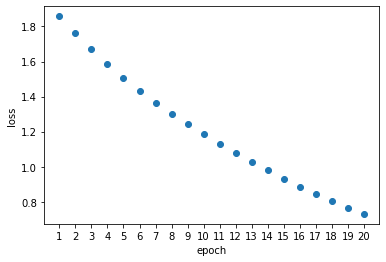

In [44]:
plt.plot([i+1 for i in range(len(losses))],  losses, "o")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xticks([i+1 for i in range(len(losses))])
plt.show()

In [47]:
scored = score(model, positives_test_encoded, negatives_test_encoded)
for k in [5,10, 30]:
    recalls = [recall_k(k, pred) for pred in scored.values()]
    mean_recall = np.mean(recalls)
    print(f"Recall@{k} = {mean_recall}")

Recall@5 = 0.22307692307692306
Recall@10 = 0.22820512820512825
Recall@30 = 0.32142323629990205


### Train with sampling
for each interaction from train set sample one negative intraction. There are many ways of sampling, but for simplicity we will focus on simplest approach - random sampling.

In [48]:
n_negatives = train.shape[0]

In [49]:
users_sampled = np.random.choice(users, n_negatives)
items_sampled = np.random.choice(items, n_negatives)
negative_df = pd.DataFrame({"userId":users_sampled, "movieId":items_sampled, "output":np.zeros(n_negatives)})

In [50]:
train_sampled = pd.concat([train[["userId", "movieId"]], negative_df])
train_sampled = train_sampled.fillna(1)
train_sampled["users_mapped"] = train_sampled["userId"].apply(lambda x: u_to_ids[x])
train_sampled["items_mapped"] = train_sampled["movieId"].apply(lambda x: i_to_ids[x])

In [51]:
dataset_sampled = MovieLensDataset(train_sampled)
dataloader_sampled = DataLoader(dataset_sampled, batch_size=batch_size, shuffle=True)


model = MatrixFactorization(n_factors=20, n_users=n_users, n_items=n_items)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.BCEWithLogitsLoss()

In [52]:
# TODO n_epochs=20
train_fn(model, optimizer, n_epochs=10, dataloader=dataloader_sampled)


Running epoch 1


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 411.99it/s]


Avg loss after epoch 1, is equal to 1.8401469694075152
Running epoch 2


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 495.21it/s]


Avg loss after epoch 2, is equal to 1.7137992132957025
Running epoch 3


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 460.87it/s]


Avg loss after epoch 3, is equal to 1.5994389081315272
Running epoch 4


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 460.36it/s]


Avg loss after epoch 4, is equal to 1.4974245762113478
Running epoch 5


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 445.29it/s]


Avg loss after epoch 5, is equal to 1.4064033063163461
Running epoch 6


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 461.27it/s]


Avg loss after epoch 6, is equal to 1.325462870603762
Running epoch 7


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 439.73it/s]


Avg loss after epoch 7, is equal to 1.253332562595254
Running epoch 8


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 482.26it/s]


Avg loss after epoch 8, is equal to 1.188744532304809
Running epoch 9


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 466.25it/s]


Avg loss after epoch 9, is equal to 1.1305756301026175
Running epoch 10


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 494.38it/s]

Avg loss after epoch 10, is equal to 1.077807324660899


[1.8401469694075152,
 1.7137992132957025,
 1.5994389081315272,
 1.4974245762113478,
 1.4064033063163461,
 1.325462870603762,
 1.253332562595254,
 1.188744532304809,
 1.1305756301026175,
 1.077807324660899]

In [54]:
scored = score(model, positives_test_encoded, negatives_test_encoded)
for k in [5,10, 30]:
    recalls = [recall_k(k, pred) for pred in scored.values()]
    mean_recall = np.mean(recalls)
    print(f"Recall@{k} = {mean_recall}")

Recall@5 = 0.2076923076923077
Recall@10 = 0.23461538461538464
Recall@30 = 0.33687505557289515


## Conclusions